In [1]:
!pip install -q tqdm observations
!git clone https://git@github.com/wenkesj/alchemy.git
!(cd ~/alchemy; pip install -q .)

fatal: destination path '/content/alchemy' already exists and is not an empty directory.


In [0]:
from observations import mnist

(x_train, y_train), (x_test, y_test) = mnist('data')
train_size, test_size = len(x_train), len(x_test)

# Shared Model Body for comparison

In [0]:
import alchemy as ay
import tensorflow as tf

def model_fn(inputs_ph):
  inputs = tf.reshape(inputs_ph, [tf.shape(inputs_ph)[0], 28, 28, 1])
  y = tf.layers.conv2d(tf.cast(inputs, tf.float32) / 127, 32, (3, 3), 
                       activation=tf.nn.relu)
  y = tf.layers.conv2d(y, 64, (3, 3), activation=tf.nn.relu)
  y = tf.contrib.layers.flatten(y)
  return y

In [0]:
import numpy as np
import sys
from tqdm import trange

epochs = 2
batch_size = 64
learning_rate = 8.25e-4


def train_fn(model):
  tf.reset_default_graph()
  tf.set_random_seed(42)
  np.random.seed(42)

  tf.reset_default_graph()
  
  inputs_ph = tf.placeholder(tf.uint8, (None, 784), name='inputs')
  labels_ph = tf.placeholder(tf.int32, (None,), name='labels')

  logits = model_fn(inputs_ph)
  logits, kernels = model(logits)

  pred_op = tf.argmax(logits, axis=-1, output_type=tf.int32)
  accy_op = tf.reduce_mean(
      tf.cast(tf.equal(pred_op, labels_ph), tf.float32), axis=-1)
  loss_op = tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=labels_ph, logits=logits, name='loss'),
      axis=-1)
  train_op = tf.train.AdamOptimizer(
      learning_rate=learning_rate).minimize(loss_op)
  
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    accuracies = []
    for epoch in range(epochs):
      train_loss = 0.
      train_set = ay.utils.generate_dataset((x_train, y_train), batch_size)
      train_msg = 'Epoch {} mean train loss = {:.4f}'
      train_range = trange(
          train_size // batch_size, 
          desc=train_msg.format(epoch, train_loss),
          file=sys.stdout)
      for _ in train_range:
        x, y = next(train_set)
        train_loss, _ = sess.run((loss_op, train_op), feed_dict={
            inputs_ph: x,
            labels_ph: y, 
        })
        train_range.set_description(train_msg.format(epoch, train_loss))

      test_accy = 0.
      test_set = ay.utils.generate_dataset((x_test, y_test), batch_size)
      for test_steps_taken in range(test_size // batch_size):
        x, y = next(test_set)
        test_accy_ = sess.run(accy_op, feed_dict={
            inputs_ph: x,
            labels_ph: y,
        })
        test_accy += test_accy_
      accy = 100. * (test_accy / (test_steps_taken + 1))
      accuracies.append(accy)
      print('Epoch {} accy {:.2f}%'.format(epoch, accy))
    return accuracies, sess.run(kernels)

# Compare

In [0]:
def dense(logits):
  kernels = []
  dense = tf.layers.Dense(units=128, activation=tf.nn.relu)
  logits = dense(logits)
  kernels.append(dense.kernel)

  dense = tf.layers.Dense(units=10, activation=tf.nn.relu)
  logits = dense(logits)
  kernels.append(dense.kernel)
  
  logits = tf.layers.dense(logits, units=128, activation=tf.nn.relu)
  return logits, kernels


def lateral_with_self_connections(logits):
  kernels = []
  dense = tf.layers.Dense(units=128, activation=None)
  logits = dense(logits)

  lateral = ay.contrib.layers.Lateral(
      use_bias=False,
      allow_self_connections=True, 
      activation=tf.nn.relu,
      name='lateral_1')
  logits = lateral(logits)
  kernel = tf.transpose(
      tf.nn.softmax(
          tf.transpose(lateral.kernel, [1, 0])))
  kernels.append(kernel)
  

  dense = tf.layers.Dense(units=10, activation=None)
  logits = dense(logits)

  lateral = ay.contrib.layers.Lateral(
      use_bias=False,
      allow_self_connections=True,
      name='lateral_1')
  logits = lateral(logits)
  kernel = tf.transpose(
      tf.nn.softmax(
          tf.transpose(lateral.kernel, [1, 0])))
  kernels.append(kernel)
  return logits, kernels


def lateral_without_self_connections(logits):
  kernels = []
  dense = tf.layers.Dense(units=128, activation=None)
  logits = dense(logits)

  lateral = ay.contrib.layers.Lateral(
      use_bias=False,
      activation=tf.nn.relu,
      name='lateral_1')
  logits = lateral(logits)
  kernel = tf.transpose(
      tf.nn.softmax(
          tf.transpose(lateral.kernel, [1, 0])))
  kernels.append(kernel)

  dense = tf.layers.Dense(units=10, activation=None)
  logits = dense(logits)

  lateral = ay.contrib.layers.Lateral(
      use_bias=False,
      name='lateral_1')
  logits = lateral(logits)
  kernel = tf.transpose(
      tf.nn.softmax(
          tf.transpose(lateral.kernel, [1, 0])))
  kernels.append(kernel)
  return logits, kernels

models = [
    dense,
    lateral_with_self_connections, 
    lateral_without_self_connections]

Epoch 0 mean train loss = 0.3730: 100%|██████████| 937/937 [00:18<00:00, 51.74it/s]
Epoch 0 accy 97.62%
Epoch 1 mean train loss = 0.1548:   4%|▍         | 36/937 [00:00<00:18, 47.47it/s]

Epoch 1 mean train loss = 0.2943: 100%|██████████| 937/937 [00:17<00:00, 54.22it/s]
Epoch 1 accy 98.25%
Epoch 0 mean train loss = 0.5099:   6%|▌         | 57/937 [00:01<00:17, 49.64it/s]

Epoch 0 mean train loss = 0.3187: 100%|██████████| 937/937 [00:17<00:00, 53.99it/s]
Epoch 0 accy 97.61%
Epoch 1 mean train loss = 0.1301:   7%|▋         | 65/937 [00:01<00:16, 52.48it/s]

Epoch 1 mean train loss = 0.2872: 100%|██████████| 937/937 [00:17<00:00, 54.35it/s]
Epoch 1 accy 98.34%
Epoch 0 mean train loss = 0.2616:   7%|▋         | 67/937 [00:01<00:18, 47.88it/s]

Epoch 0 mean train loss = 0.3214: 100%|██████████| 937/937 [00:17<00:00, 53.98it/s]
Epoch 0 accy 98.03%
Epoch 1 mean train loss = 0.0461:   8%|▊         | 72/937 [00:01<00:16, 53.67it/s]

Epoch 1 mean train loss = 0.2553: 100%|██████████| 937/937 [00:17<00:00, 53.90it/s]
Epoch 1 accy 98.52%


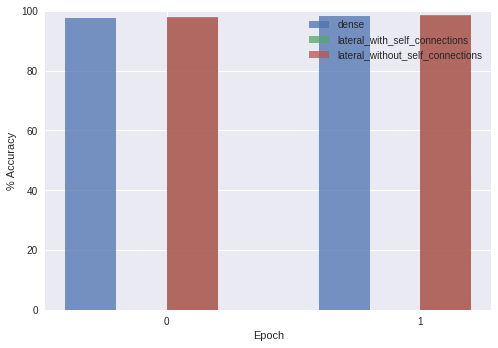

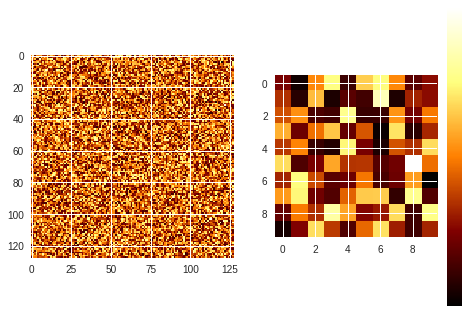

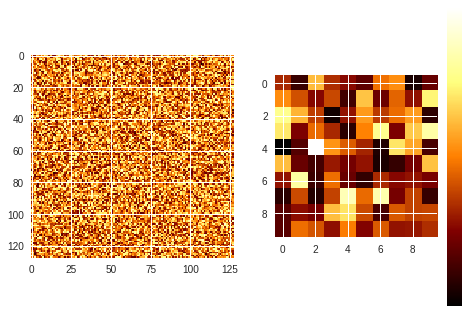

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

_, accy_ax = plt.subplots()
accy_ax.set_ylabel('% Accuracy')
accy_ax.set_xlabel('Epoch')
accy_ax.set_ylim([0, 100.])

index = np.arange(epochs)
bar_width = 0.2
opacity = 0.75

for idx, (name, (accuracies, variables)) in enumerate([(model.__name__, train_fn(model)) 
                                                       for model in models]):
  if 'lateral_' in name:
    idx = 0
    f, vars_ax = plt.subplots(1, len(variables))
    for lateral in variables:
      cax = vars_ax[idx].imshow(lateral, interpolation='nearest', cmap=cm.afmhot)
      idx += 1
    cbar = f.colorbar(cax, ticks=[-1, 0, 1])

  accy_ax.bar(index + (idx * bar_width), accuracies, bar_width, 
              alpha=opacity, label=name)

accy_ax.set_xticks(index + len(models) * bar_width / 2)
accy_ax.set_xticklabels(list(map(lambda x: str(int(x)), index.tolist())))
accy_ax.legend()